In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import export_graphviz, plot_tree
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from treeinterpreter import treeinterpreter
from fastai.tabular import *
sns.set()

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
df_raw = pd.read_csv('churn2.csv')


In [9]:
display_all(df_raw.head())

,state,area_code,account_length,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,415,128,(415) 382-4657,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,415,107,(415) 371-7191,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,415,137,(415) 358-1921,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,84,(408) 375-9999,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,75,(415) 330-6626,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [10]:
y = df_raw['churn']
df = df_raw.drop(['churn', 'phone_number'], axis=1)

In [11]:
class DFProc():
    def __call__(self, df, test=False):
        func = self.apply_test if test else self.apply_train
        return func(df)
    def apply_train(self, df):
        raise NotImplementedError
    def apply_test(self, df):
        self.apply_train(df)
        
class ProcCategory(DFProc):
    def __init__(self, cat_names):
        self.cat_names = cat_names
        self.categories = {}
        
    def apply_train(self, df):
        for i in self.cat_names:
            df.loc[:, i] = df.loc[:, i].astype('category').cat.as_ordered()
            self.categories[i] = df.loc[:, i].cat.categories
            df[i] = df[i].cat.codes
        return df   
    def apply_test(self, df):
        for i in self.cat_names:
            df[i] = pd.Categorical(df[i], categories=self.categories[i])
            df[i] = df[i].cat.codes
        return df
    
class Normalize(DFProc):
    def __init__(self, cont_vars):
        self.cont_vars = cont_vars
        self.means = {}
        self.stds = {}
    
    def apply_train(self, df):
        for c in self.cont_vars:
            self.means[c] = df.loc[:, c].mean()
            self.stds[c] = df.loc[:, c].std()
            df.loc[:, c] = (df.loc[:, c] - self.means[c]) / (1e-7 + self.stds[c])
        return df
    
    def apply_test(self, df):
        for c in self.cont_vars:
            df.loc[:, c] = (df.loc[:, c] - self.means[c]) / (1e-7 + self.stds[c])
        return df

In [126]:
df['total charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge'] + df['total intl charge']

In [127]:
df['many service call'] = df['customer service calls'] >= 4

In [128]:
df['charge_min_ratio'] = df['total charge'] / (df['total day minutes'] + df['total eve minutes'] + df['total night minutes'] + df['total intl minutes'])

In [12]:
cat_var = ['state', 'area_code', 'international_plan', 'voice_mail_plan']
num_var = ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge',
           'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls',
           'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls']

In [13]:
proc = ProcCategory(cat_var)
df = proc(df)

In [14]:
display_all(df)

,state,area_code,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,16,1,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,35,1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,31,1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,35,0,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,36,1,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
5,1,2,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
6,19,2,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3
7,24,1,147,1,0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0
8,18,0,117,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1
9,49,1,141,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0


In [18]:
train_idx = np.load('train_idx.npy')
valid_idx = np.load('valid_idx.npy')

In [19]:
def print_score(m):
    y_train_pred = m.predict(X_train)
    y_valid_pred = m.predict(X_valid)
    print('Train accuracy ', m.score(X_train, y_train))
    print('Train recall ', recall_score(y_train, y_train_pred))
    print('Validation accuracy ', m.score(X_valid, y_valid))
    print('validation recall ', recall_score(y_valid, y_valid_pred))
#     if hasattr(m, 'oob_score_'): print('oob score ', m.oob_score_)

In [53]:
X_train, X_valid, y_train, y_valid = df.iloc[train_idx], df.iloc[valid_idx], y[train_idx], y[valid_idx]

In [99]:
rf = RandomForestClassifier(1000, criterion='entropy', min_samples_leaf=5, max_features=0.6,
                             n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=0.6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [49]:
df['many_service_call'] = df['customer_service_calls']

In [50]:
keep_cols = np.load('keep_cols.npy')
keep_cols = np.array(['total_intl_charge', 'customer_service_calls', 'total_eve_charge', 'number_vmail_messages',
       'international_plan', 'total_intl_calls', 'total_night_charge', 'total_day_charge', 'many_service_call'])

In [51]:
df[keep_cols].shape

(3333, 9)

In [54]:
X_train = X_train[keep_cols]
X_valid = X_valid[keep_cols]

In [55]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={False: 0.6, True: 3.3},
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

rf.fit(X_train[keep_cols], y_train)
print_score(rf)

Train accuracy  0.9634101719721917
Train recall  0.8611111111111112
Validation accuracy  0.9516666666666667
validation recall  0.8850574712643678


In [56]:
def score(X, y):
    y_pred = rf.predict(X)
    return recall_score(y, y_pred)
def plot_imp(imp): 
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(imp['Feature'], imp['Importance'])

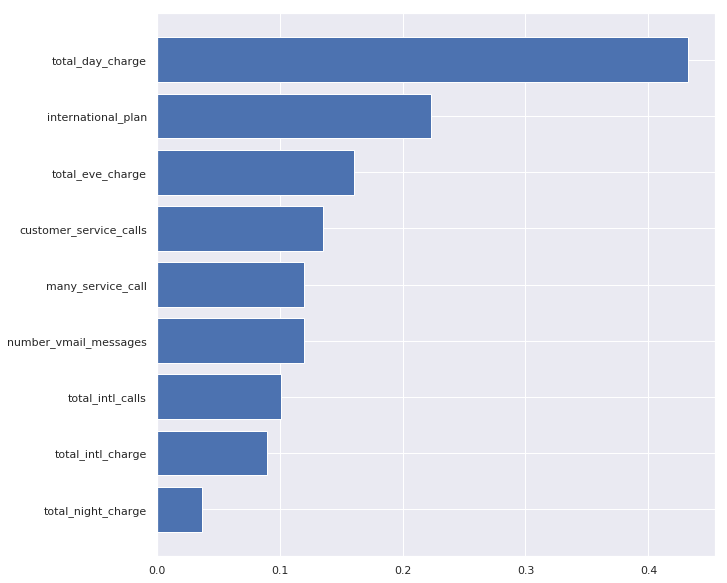

In [57]:
imp = get_score_importances(score, X_valid.values, y_valid.values)
recall_drop_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.array(imp[1]).mean(axis=0)}).sort_values('Importance')
plot_imp(recall_drop_imp)

In [63]:
feat_imp = {}
for i, k in enumerate(recall_drop_imp.to_dict('list')['Feature']):
    feat_imp[k] = recall_drop_imp.to_dict('list')['Importance'][i]

In [67]:
pickle.load(open('feat_imp.pkl', 'rb'))

{'total_night_charge': 0.03678160919540237,
 'total_intl_charge': 0.0896551724137931,
 'total_intl_calls': 0.10114942528735638,
 'number_vmail_messages': 0.11954022988505748,
 'many_service_call': 0.11954022988505755,
 'customer_service_calls': 0.13563218390804604,
 'total_eve_charge': 0.16091954022988508,
 'international_plan': 0.2229885057471265,
 'total_day_charge': 0.4321839080459771}

In [60]:
recall_drop_imp.to_dict('list')

{'Feature': ['total_night_charge',
  'total_intl_charge',
  'total_intl_calls',
  'number_vmail_messages',
  'many_service_call',
  'customer_service_calls',
  'total_eve_charge',
  'international_plan',
  'total_day_charge'],
 'Importance': [0.03678160919540237,
  0.0896551724137931,
  0.10114942528735638,
  0.11954022988505748,
  0.11954022988505755,
  0.13563218390804604,
  0.16091954022988508,
  0.2229885057471265,
  0.4321839080459771]}